This is the third simple toy model to adapt the LLH NN from Ice Cube to tracker geometry. We're using curved tracks, 8 detector layers. The detector layers are now binned and each bin only registers hit/no hit, with 100% efficiency. Assume hits are still Gaussian distributed before registering.

Training on larger parameter range now with 1e6 samples.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from scipy import stats
from scipy import constants
from scipy.special import erf
import types
from scipy.optimize import minimize, Bounds

from LLH_NN_utils import *

### Tracker toy model

Muon decaying at (x=0,z), producing positron with momentum (px,pz). 8 layers at given z (infinite in x) that will return x position (Gaussian). $\vec{B} = B\hat{y}$

Since the Lorentz force only acts perpendicular to the direction of motion, $|v|$ and $\gamma$ don't change, and the time derivative is simply
$\frac{d\vec{v}}{dt} = \frac{q}{\gamma m} (\vec{v} \times \vec{B}) = \frac{qB}{\gamma m} (v_x \hat{z} - v_z\hat{x})$

$v_x = A\sin(\frac{qB}{\gamma m} t + \phi)$<br/>
$v_z = A\cos(\frac{qB}{\gamma m} t + \phi)$

$|v|^2 = v_x^2 + v_z^2 = A^2$<br/>
$p_x = |p|\sin(\frac{qB}{\gamma m} t + \phi)$<br/>
$p_z = |p|\cos(\frac{qB}{\gamma m} t + \phi)$

$\tan \phi = \frac{v_x(0)}{v_z(0)} = \frac{p_x(0)}{p_z(0)}$

$x = \int_0^T v_x dt = -\frac{\gamma m}{qB} |v| (\cos(\frac{qB}{\gamma m} T + \phi) - \frac{v_z(0)}{|v|})$<br/>
$z = \int_0^T v_z dt = \frac{\gamma m}{qB} |v| (\sin(\frac{qB}{\gamma m} T + \phi) - \frac{v_x(0)}{|v|})$

$z$ is fixed, so<br/>
$T = \frac{\gamma m}{qB}(\arcsin(\frac{qBz +\gamma mv_x(0)}{\gamma m |v|}) - \phi)$

$x = \frac{\gamma m v_z(0)}{qB} - \frac{\gamma m|v|}{qB}\cos(\arcsin(\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})) = \frac{\gamma m v_z(0)}{qB} - \frac{\gamma m|v|}{qB}\sqrt{1 - (\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})^2} = \frac{\gamma m v_z(0)}{qB} - \frac{1}{qB}\sqrt{\gamma^2m^2|v|^2 - (qBz +\gamma mv_x(0))^2}$<br/>
$x = \frac{\gamma m v_z(0)}{qB} - \frac{1}{qB}\sqrt{\gamma^2m^2v_z^2(0) - q^2B^2z^2 -2qBz\gamma mv_x(0)} = \frac{p_z(0)}{qB} - \frac{1}{qB}\sqrt{p_z^2(0) - q^2B^2z^2 -2qBzp_x(0)}$

Change to use $|p|(0) = p$ and initial angle $\phi$ (from the z-axis):<br/>
$x = \frac{p\cos(\phi)}{qB} - \frac{1}{qB}\sqrt{p^2\cos^2(\phi) - q^2B^2z^2 -2qBzp\sin(\phi)}$

In [73]:
#leave out e in momentum calc, and q's above

c = constants.c
#e = constants.e
B = 1.45
#phi = lambda vx,vz: np.arctan2(vx,vz)
N_det = 8
det_zs = np.linspace(0,(N_det-1)*0.12,N_det) #z-layers
l_bin = 5e-3 #length of bin
l_gap = 1e-3 #length of gap between bins

def calc_x(z,p,phi):
    # p is in GeV -> *1e9/c
    p *= 1e9/c
    
    sq = p**2*np.cos(phi)**2 - B**2*z**2 - 2*B*z*p*np.sin(phi)
    sq = np.sqrt(sq)

    return (p*np.cos(phi) - sq)/B

#x position is normal distribution
x_hit = lambda x,sigma: stats.norm(loc=x, scale=sigma)

#example event z_toy,p_toy,phi_toy
#toy=[-0.34,1.9,0.06]
toy=[-0.33,1.92,0.057]  #this should produce an event that hits one gap, might have to run it a couple times
z_toy, p_toy, phi_toy = toy

#for Gaussian
sigma = 3e-4

In [22]:
def generate_event(z, p, phi):
    # generates an event from given z, p, phi
    # returns length 8 array of centers of hit bins
    
    xs = np.zeros(N_det)
    dist = det_zs-z
    x_exp = calc_x(dist,p,phi)
    for i in range(N_det):
        if np.isnan(x_exp[i]): pass #need to handle this later, set to -1?
        x_meas = x_hit(x_exp[i],sigma).rvs()
        #let's say 0 is in middle of gap 
        #-> first center is 3mm, 2nd is 9, 3rd is 15 etc
        #lower edge: (n-1)*6mm + 0.5mm = n*6 - 5.5
        #upper edge: n*6 - 0.5
        
        #first check what's the closest lower edge
        n = (x_meas + 5.5e-3)//6e-3
        #calculate center of that bin
        center = n*6e-3 - 3e-3
        #if hit is within upper edge, set value to center
        #else leave at 0 (no hit)
        if x_meas<=(n*6e-3 - 0.5e-3):
            xs[i] = center
    return xs

#toy MC
def MC_events(N_events, zlims=(-0.5, -0.001), plims=(1.5,3), phi_lims=(0,np.pi/8)):
    '''
    sample source parameters from uniform distribution of x, p, and phi #isn't really uniform dist
    and generate events using those.
    N_events : int
        number of desired events
    *_lims : tuple
        lower and upper bount of the uniform to sample from
        
    Returns:
    events : list of generated events
    truth : true parameters
    '''

    # truth array z,p,phi
    # p is in GeV -> *1e9/c
    

    z = np.random.uniform(*zlims, N_events)
    p = np.random.uniform(*plims, N_events)
    phi = np.random.uniform(*phi_lims, N_events)

    truth = np.vstack([z, p, phi]).T

    events = []

    for i in range(N_events):
        events.append(generate_event(z[i], p[i], phi[i]))

    return events, truth

In [27]:
def plot_event(x_meas,z,p,phi):
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.set_title('hit locations')
    ax.set_xlabel('x')
    
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    x_exp = calc_x(det_zs-z,p,phi)
    for i, z_det in enumerate(det_zs):
        #expectation
        x_dist = x_hit(x_exp[i],sigma)
        mu = x_dist.mean()
        std = x_dist.std()
        times = np.linspace(mu - 3*std, mu + 3*std, 1000)
        ax.plot(times, x_dist.pdf(times),label=f'z={100*det_zs[i]:.0f} cm')
        
        #measured
        if x_meas[i]>0:
            ax.bar(x_meas[i], 100, width=5e-3, alpha=0.5,
                    color=color_cycle[i % len(color_cycle)])
            
    #bins
    minval = np.min(x_meas[np.nonzero(x_meas)])
    maxval = max(x_meas.max(),x_exp.max())
    n_min = int((minval + 5.5e-3)//6e-3)
    n_max = int((maxval + 5.5e-3)//6e-3)
    for n in range(n_min,n_max+1):
        center = n*6e-3 - 3e-3
        #ax.bar(center, 100, width=5e-3, alpha=0.1, color='grey')
        ax.step(center+np.array([-5e-3,0,5e-3]), np.array([0,100,0]), 'k--', where='mid', linewidth=1)

    ax.set_yticklabels([])
    
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

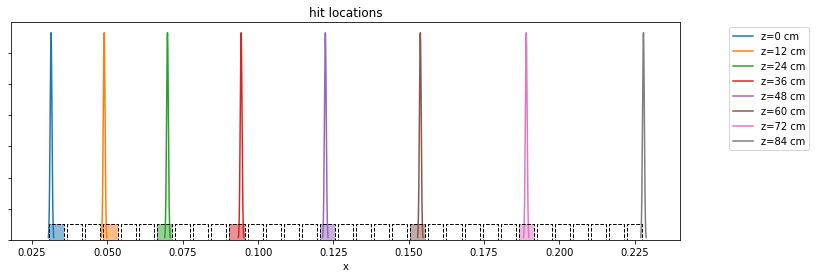

In [74]:
ev = generate_event(*toy)
plot_event(ev,*toy)

$L = \Pi_{i=1}^8 \frac{1}{\sqrt{2\pi}\sigma} \exp(-\frac{(x_{meas}-x_{exp})^2}{2\sigma^2})$<br/>
$\log(L) = \sum_{i=1}^8 -\frac{(x_{meas}-x_{exp})^2}{2\sigma^2} - \log(\sqrt{2\pi}\sigma)$

In [35]:
#log-likelihoods

def hit_pdf(x_meas,z,p,phi):
    xs = calc_x(det_zs-z,p,phi)

    llh = 0
   
    for i,hit in enumerate(x_meas):
        #if we registered a hit
        if hit>0:
            #integrate Gaussian over bin area -> erf
            pmf = 0.5*(erf((hit+2.5e-3-xs[i])/sigma/np.sqrt(2)) - erf((hit-2.5e-3-xs[i])/sigma/np.sqrt(2)))
            #to avoid infs and problems in log, have to deal with very small integrals manually
            if pmf==0: llh -= 710 #np.log(1e-308) = -709.2, smallest possible number in 64 bit system
            else: llh += np.log(pmf)
        else:
            #determine closest gaps: n, n-1, n+1
            n = (xs[i]+5.5e-3)//6e-3
            pmf = 0
            for m in [n-1, n, n+1]:
                gap_end = m*6e-3 + 0.5e-3
                #integrate over gap
                pmf += 0.5*(erf((gap_end-xs[i])/sigma/np.sqrt(2)) - erf((gap_end-1e-3-xs[i])/sigma/np.sqrt(2)))
            if pmf==0: llh -= 710
            else: llh += np.log(pmf)
    
    #store negative LLH, multiply by -1
    return -llh

In [34]:
#alternative (only run one of these)

def hit_pdf_alt(x_meas,z,p,phi):
    xs = calc_x(det_zs-z,p,phi)

    llh = 0
    pmf=1
   
    for i,hit in enumerate(x_meas):
        #if we registered a hit
        if hit>0:
            #integrate Gaussian over bin area -> erf
            pmf *= 0.5*(erf((hit+2.5e-3-xs[i])/sigma/np.sqrt(2)) - erf((hit-2.5e-3-xs[i])/sigma/np.sqrt(2)))
        else:
            #determine closest gaps: n, n-1, n+1
            n = (xs[i]+5.5e-3)//6e-3
            pmf_s = 0
            for m in [n-1, n, n+1]:
                gap_end = m*6e-3 + 0.5e-3
                #integrate over gap
                pmf_s += 0.5*(erf((gap_end-xs[i])/sigma/np.sqrt(2)) - erf((gap_end-1e-3-xs[i])/sigma/np.sqrt(2)))
            pmf *= pmf_s
    if pmf==0: llh=-710
    else: llh = np.log(pmf)    
    
    #store negative LLH, multiply by -1
    return -llh

In [75]:
grid_spacing = 100

#full range
zs = np.linspace(-0.5,-0.001, grid_spacing)
ps = np.linspace(1.5, 3, grid_spacing)
phis = np.linspace(0, np.pi/8, grid_spacing)

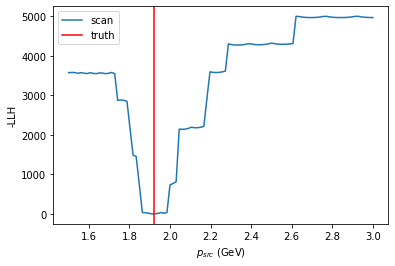

In [76]:
llh_p_scan = map_1d(hit_pdf, ev, 1, ps, toy)

plot_1d_scan(llh_p_scan, ps, p_toy, '$p_{src}$ (GeV)')

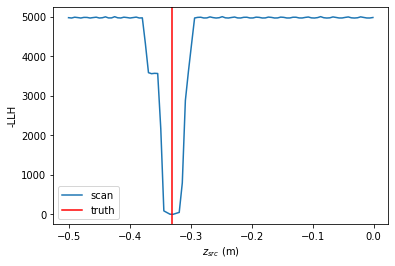

In [77]:
llh_z_scan = map_1d(hit_pdf, ev, 0, zs, toy)

plot_1d_scan(llh_z_scan, zs, z_toy, '$z_{src}$ (m)')

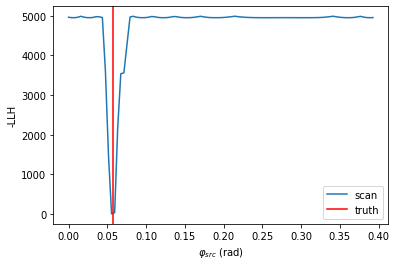

In [78]:
llh_phi_scan = map_1d(hit_pdf, ev, 2, phis, toy)

plot_1d_scan(llh_phi_scan, phis, phi_toy, r'$\varphi_{src}$ (rad)')

We can see the steps in the graphs here that come from the discrete element of the experiment. The steps are a little misleading, if you actually calculate the log-likelihood by first multiplying the likelihoods and then taking the log (instead of sum of logs of individual likelihoods), there is only one step visible. So we will have to zoom into the "first" step and only within that interval is the analytic likelihood realistic, beyond that we should assume it goes to infinity.

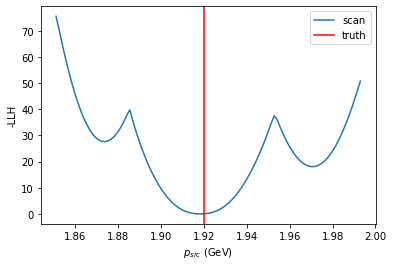

In [79]:
#zooming in
#p_zoom = (1.859,1.954)
p_zoom = (1.851,1.993)
ps = np.linspace(*p_zoom, grid_spacing)

llh_p_scan = map_1d(hit_pdf, ev, 1, ps, toy)

plot_1d_scan(llh_p_scan, ps, p_toy, '$p_{src}$ (GeV)')

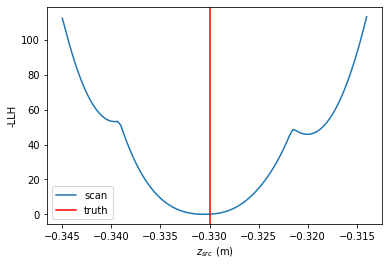

In [80]:
#z_zoom = (-0.349,-0.326)
z_zoom = (-0.345,-0.314)
zs = np.linspace(*z_zoom, grid_spacing)

llh_z_scan = map_1d(hit_pdf, ev, 0, zs, toy)

plot_1d_scan(llh_z_scan, zs, z_toy, '$z_{src}$ (m)')

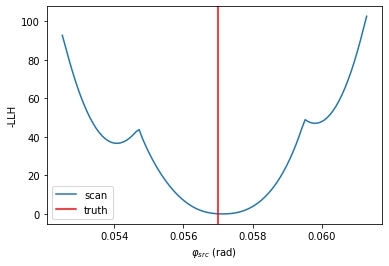

In [81]:
#phi_zoom = (0.0562, 0.0627)
phi_zoom = (0.0525, 0.0613)
phis = np.linspace(*phi_zoom, grid_spacing)

llh_phi_scan = map_1d(hit_pdf, ev, 2, phis, toy)

plot_1d_scan(llh_phi_scan, phis, phi_toy, r'$\varphi_{src}$ (rad)')

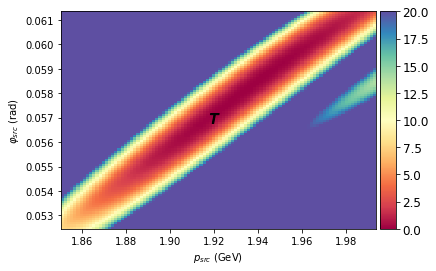

In [82]:
llh_p_phi_scan = map_2d(hit_pdf, ev, (1, 2), (ps, phis), toy)

plot_2d_scan(llh_p_phi_scan, ps, phis, p_toy, phi_toy,
                   axis_labels=['$p_{src}$ (GeV)', r'$\varphi_{src}$ (rad)'],vmax=20)

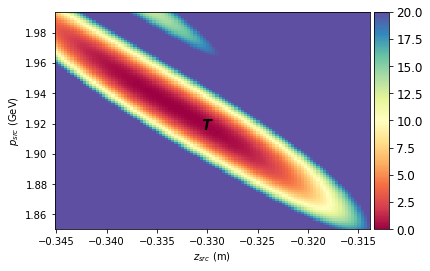

In [83]:
llh_z_p_scan = map_2d(hit_pdf, ev, (0, 1), (zs,ps), toy)

plot_2d_scan(llh_z_p_scan, zs,ps,z_toy, p_toy,
                   axis_labels=['$z_{src}$ (m)','$p_{src}$ (GeV)'],vmax=20)

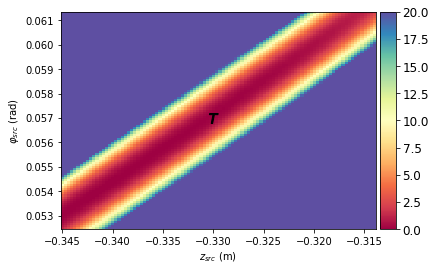

In [84]:
llh_z_phi_scan = map_2d(hit_pdf, ev, (0, 2), (zs,phis), toy)

plot_2d_scan(llh_z_phi_scan, zs,phis,z_toy, phi_toy,
                   axis_labels=['$z_{src}$ (m)',r'$\varphi_{src}$ (rad)'],vmax=20)

We can see that there's plateau's both in 1D and 2D around the truth values, so it might be hard for the neural net to reconstruct this. If nothing else, we can expect minimization to be imprecise.

In [45]:
#make toy MC data for neural net training
N_mc = int(1e6)
mc, truth = MC_events(N_mc)

In [46]:
#neural nets

hitnet = types.SimpleNamespace() 

hitnet.events = mc

#separate the hits into single events, add the detector z position
hitnet.events = np.concatenate(hitnet.events)
hitnet.events = np.vstack((hitnet.events,np.tile(det_zs,N_mc))).T

hitnet.truth = np.repeat(truth, N_det, axis=0)

assert hitnet.events.shape[0] == hitnet.truth.shape[0]

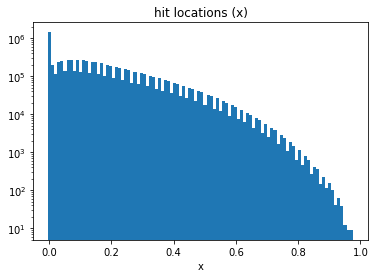

In [47]:
#histogram of hit positions (x) = bin centers
plt.hist(hitnet.events[:,0], bins=100)
plt.gca().set_yscale('log')
plt.title('hit locations (x)')
plt.xlabel('x')
plt.show()

In [48]:
#need trafo to combine measurements and (hypothetical) input params into input for NN
class trafo(tf.keras.layers.Layer):

    def call(self, hits, theta):
        out = tf.stack([
                 hits[:,0],
                 hits[:,1],
                 theta[:,0],
                 theta[:,1],
                 theta[:,2]
                ],
                axis=1
                )
#        out = tf.concat([charges[:,:1],r2,theta],axis=1)
        return out

hitnet.trafo = trafo

In [49]:
#make training and test datasets
hitnet.x_train, hitnet.x_test, hitnet.t_train, hitnet.t_test = train_test_split(hitnet.events, hitnet.truth, test_size=0.2, random_state=42)
hitnet.d_train = make_dataset(hitnet.x_train, hitnet.t_train)
hitnet.d_test = make_dataset(hitnet.x_test, hitnet.t_test)

In [50]:
## Neural Net

activation='relu'

x_input = tf.keras.Input(shape=(hitnet.x_train.shape[1],))
t_input = tf.keras.Input(shape=(hitnet.t_train.shape[1],))

h = hitnet.trafo()(x_input, t_input)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(128, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

hitnet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
hitnet.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
trafo (trafo)                   (None, 5)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           192         trafo[0][0]                  

In [51]:
optimizer = tf.keras.optimizers.Adam(0.001)
hitnet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [52]:
#training

hitnet.hist = hitnet.model.fit(hitnet.d_train, epochs=5, verbose=1, validation_data=hitnet.d_test)

Epoch 1/5
3125/3125 [==============================] - 193s 62ms/step - loss: 0.3539 - val_loss: 0.1886
Epoch 2/5
3125/3125 [==============================] - 204s 65ms/step - loss: 0.2242 - val_loss: 0.1811
Epoch 3/5
3125/3125 [==============================] - 192s 61ms/step - loss: 0.2169 - val_loss: 0.1817
Epoch 4/5
3125/3125 [==============================] - 201s 64ms/step - loss: 0.2022 - val_loss: 0.1818
Epoch 5/5
3125/3125 [==============================] - 206s 66ms/step - loss: 0.1989 - val_loss: 0.1708


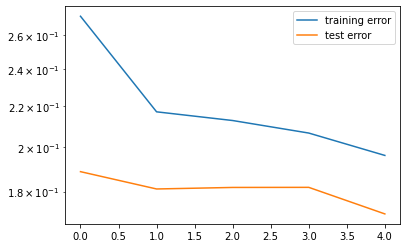

In [53]:
plt.plot(hitnet.model.history.history['loss'],label='training error')
plt.plot(hitnet.model.history.history['val_loss'],label='test error')
plt.gca().set_yscale('log')
plt.legend()
plt.show()

#compile neural net
#log(sigmoid) = linear -> change last layer to get llh
hitnet.llh = tf.keras.models.clone_model(hitnet.model)
hitnet.llh.set_weights(hitnet.model.get_weights())
hitnet.llh.layers[-1].activation = tf.keras.activations.linear #result is log r(x,theta)
hitnet.llh.compile()

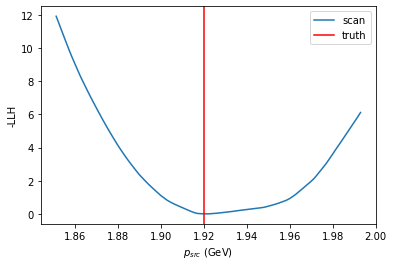

In [85]:
#neural net scan
#ps = np.linspace(*p_zoom,grid_spacing)

scan_t = np.vstack([np.ones(grid_spacing)*z_toy,ps,np.ones(grid_spacing)*phi_toy]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

scan_x = np.tile(ev,grid_spacing)
scan_x = np.vstack((scan_x,np.tile(det_zs,grid_spacing))).T

nn_p_scan = hitnet.llh.predict([scan_x,scan_t])

nn_p_scan = -np.sum(nn_p_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_p_scan, ps, p_toy, axis_label='$p_{src}$ (GeV)')

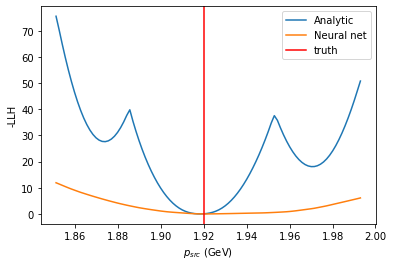

In [86]:
#comparison NN and analytical
#llh_p_scan = map_1d(hit_pdf, ev, 1, ps, toy)

plot_1d_diff(llh_p_scan, nn_p_scan, ps, p_toy, '$p_{src}$ (GeV)')

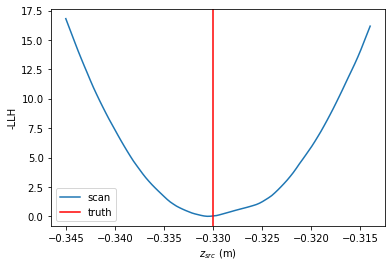

In [87]:
#neural net scan
#zs = np.linspace(*z_zoom,grid_spacing)

scan_t = np.vstack([zs,np.ones(grid_spacing)*p_toy,np.ones(grid_spacing)*phi_toy]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

nn_z_scan = hitnet.llh.predict([scan_x,scan_t])

nn_z_scan = -np.sum(nn_z_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_z_scan, zs, z_toy, axis_label='$z_{src}$ (m)')

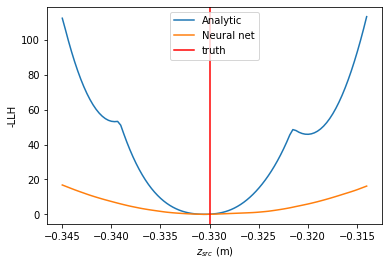

In [88]:
#comparison NN and analytical
#llh_z_scan = map_1d(hit_pdf, ev, 0, zs, toy)

plot_1d_diff(llh_z_scan, nn_z_scan, zs, z_toy, '$z_{src}$ (m)')

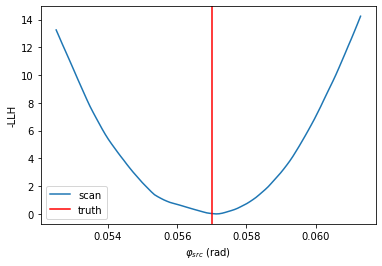

In [89]:
#neural net scan
#phis = np.linspace(*phi_zoom,grid_spacing)

scan_t = np.vstack([np.ones(grid_spacing)*z_toy,np.ones(grid_spacing)*p_toy,phis]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

nn_phi_scan = hitnet.llh.predict([scan_x,scan_t])

nn_phi_scan = -np.sum(nn_phi_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_phi_scan, phis, phi_toy, axis_label=r'$\varphi_{src}$ (rad)')

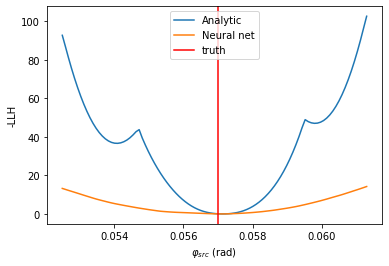

In [90]:
#comparison NN and analytical
#llh_phi_scan = map_1d(hit_pdf, ev, 2, phis, toy)

plot_1d_diff(llh_phi_scan, nn_phi_scan, phis, phi_toy, r'$\varphi_{src}$ (rad)')

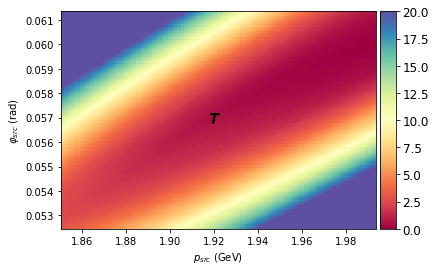

In [91]:
#neural net scan
mg = np.meshgrid(ps,phis)

hitnet.grid_t = np.vstack([np.ones(grid_spacing**2)*z_toy,mg[0].flatten(),mg[1].flatten()]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_x = np.tile(ev,grid_spacing**2)
hitnet.grid_x = np.vstack((hitnet.grid_x,np.tile(det_zs,grid_spacing**2))).T

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_p_phi_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_p_phi_scan, ps, phis, p_toy, phi_toy, 
            axis_labels=['$p_{src}$ (GeV)', r'$\varphi_{src}$ (rad)'],vmax=20)

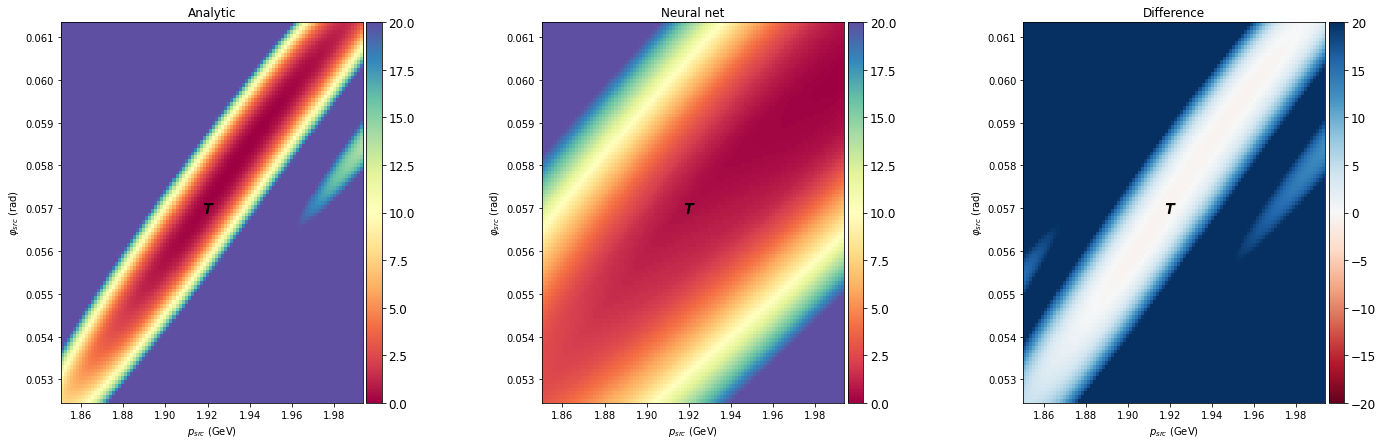

In [92]:
#comparison
#llh_p_phi_scan = map_2d(hit_pdf, ev, (1,2), (ps,phis), toy)

plot_2d_diff(llh_p_phi_scan, NN_p_phi_scan, ps, phis, p_toy, phi_toy,
             axis_labels=['$p_{src}$ (GeV)', r'$\varphi_{src}$ (rad)'],vmax=20,vmax_d=20)

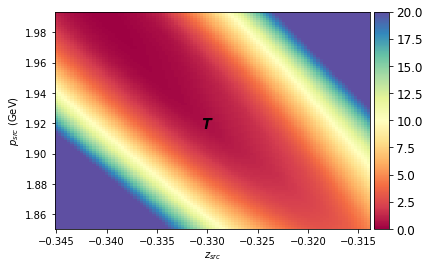

In [93]:
#neural net scan
mg = np.meshgrid(zs,ps)

hitnet.grid_t = np.vstack([mg[0].flatten(),mg[1].flatten(),np.ones(grid_spacing**2)*phi_toy]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_z_p_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_z_p_scan, zs, ps, z_toy, p_toy, 
            axis_labels=['$z_{src}$', '$p_{src}$ (GeV)'],vmax=20)

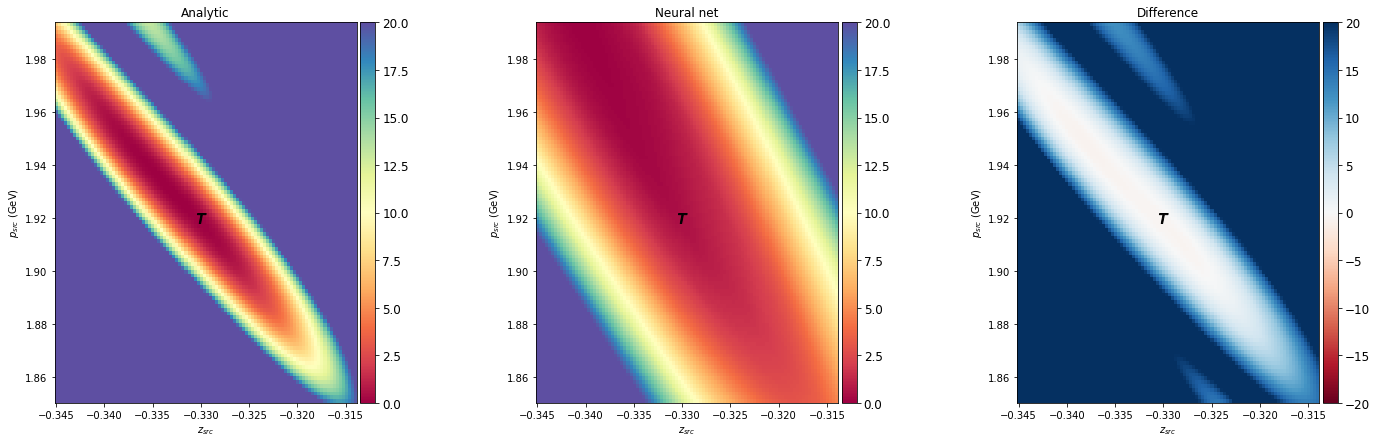

In [94]:
#comparison
#llh_z_p_scan = map_2d(ev, (0, 1), (zs,ps),z_toy,p_toy,phi_toy)

plot_2d_diff(llh_z_p_scan, NN_z_p_scan, zs, ps, z_toy, p_toy,
             axis_labels=['$z_{src}$', '$p_{src}$ (GeV)'],vmax=20,vmax_d=20)

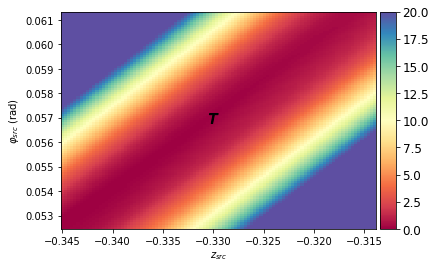

In [95]:
#neural net scan
mg = np.meshgrid(zs,phis)

hitnet.grid_t = np.vstack([mg[0].flatten(),np.ones(grid_spacing**2)*p_toy,mg[1].flatten()]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_z_phi_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_z_phi_scan, zs, phis, z_toy, phi_toy, 
            axis_labels=['$z_{src}$', r'$\varphi_{src}$ (rad)'],vmax=20)

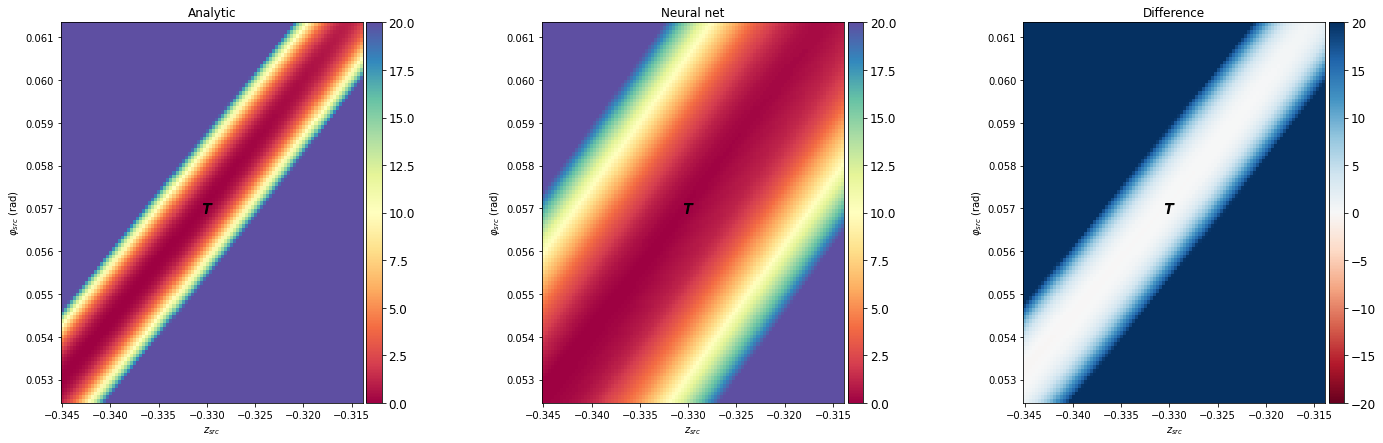

In [96]:
#comparison
#llh_z_phi_scan = map_2d(ev, (0, 2), (zs,phis),z_toy,p_toy,phi_toy)

plot_2d_diff(llh_z_phi_scan, NN_z_phi_scan, zs, phis, z_toy, phi_toy,
             axis_labels=['$z_{src}$', r'$\varphi_{src}$ (rad)'],vmax=20,vmax_d=20)

With a training range that's includes the first "llh step" in the analytic llh, the neural net learns suprisingly well, at least to the eye. It doesn't reproduce the step and doesn't show as much of a plateau, although it does reproduce a small plateau.

When the event hits a gap, the neural net doesn't hit the minimum as precisely.

In [97]:
#minimize analytic likelihood
def ana_llh(theta,event):
    #wrapper funtion
    return hit_pdf(event,*theta)

print(*toy)
true_llh_ana = ana_llh(toy,ev)
print(true_llh_ana)

-0.33 1.92 0.057
0.23219399260477327


In [98]:
#minimize nn output
def nn_llh(theta, event):
    #wrapper function
    
    #reshape events into 8x2 array 
    event = np.vstack((event,det_zs)).T

    #repeat truth for each hit in event
    theta = np.array(theta)
    theta = np.repeat(theta[np.newaxis,:], N_det, axis=0)

    #let neural net predict llh for each event, sum is total llh
    pred = hitnet.llh.predict([event,theta])
    return -1*pred.sum()

print(*toy)
true_llh_nn = nn_llh(toy,ev)
print(true_llh_nn)

-0.33 1.92 0.057
-25.56298828125


In [68]:
def bound_min(min_fct, x0, bounds, ev):
    #run a bound minimizer
    
    #x0 starting guess
    #bounds must be list of tuples, len = len(x0)
    opt_params = minimize(min_fct,x0,args=(ev),method='Powell',bounds=bounds,options={'maxiter':100000})
    
    print("starting guess:",x0)
    if opt_params.success:
        print("function value:",opt_params.fun)
        print("\nerrors:")
        print("z (mm):",1000*(opt_params.x[0]-z_toy))
        print("p (MeV):",1000*(opt_params.x[1]-p_toy))
        print("phi (rad):",(opt_params.x[2]-phi_toy))
        print("\nrelative error (%):")
        print(100*(opt_params.x - [z_toy,p_toy,phi_toy])/[z_toy,p_toy,phi_toy])
        print("\n")
        
    else: print("Minimization failed!")
        
    return opt_params.fun, opt_params.x

In [99]:
#minimize analytic llh with different starting guesses
_, opt_ana = bound_min(ana_llh,[z_zoom[0],p_zoom[0],phi_zoom[0]],[z_zoom,p_zoom,phi_zoom],ev)
_, opt_ana = bound_min(ana_llh,[z_zoom[1],p_zoom[1],phi_zoom[1]],[z_zoom,p_zoom,phi_zoom],ev)
#try truth as starting guess, see where we land (assume that's global min)
f_ana, opt_ana = bound_min(ana_llh,toy,[z_zoom,p_zoom,phi_zoom],ev)

starting guess: [-0.345, 1.851, 0.0525]
function value: 0.12529854640419746

errors:
z (mm): -13.327313755775783
p (MeV): -14.50159997131184
phi (rad): -0.004499889714454926

relative error (%):
[ 4.03857993 -0.75529167 -7.89454336]


starting guess: [-0.314, 1.993, 0.0613]
function value: 0.11605956112518195

errors:
z (mm): -1.6364208819706905
p (MeV): 16.89649056106535
phi (rad): 0.0008382430860901999

relative error (%):
[0.49588512 0.88002555 1.47060191]


starting guess: [-0.33, 1.92, 0.057]
function value: 0.11492971067093316

errors:
z (mm): 2.2622277394673818
p (MeV): 17.47182580737494
phi (rad): 0.0019483991898261513

relative error (%):
[-0.68552356  0.90999093  3.41824419]




For events with hits in all layers: 2/3 starting guesses find close to truth, very small relative errors.

For the event with one "gap hit": All 3 starting guesses produce a llh value that's lower than the truth parameters, but all of them have relative errors of order few percent in at least one parameter.

In [100]:
#minimize NN output with different starting guesses
f_nn, opt_nn = bound_min(nn_llh,[z_zoom[0],p_zoom[0],phi_zoom[0]],[z_zoom,p_zoom,phi_zoom],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth (NN/ana):",true_llh_nn, true_llh_ana)
    print("NN llh of found min:",f_nn)
    print("Analytic llh of found min (NN/ana):",ana_llh(opt_nn,ev),f_ana)

starting guess: [-0.345, 1.851, 0.0525]
function value: -26.07626724243164

errors:
z (mm): -14.984874102310197
p (MeV): 72.99896436724195
phi (rad): -0.001177857100984142

relative error (%):
[ 4.54087094  3.80202939 -2.06641597]


LLH of truth (NN/ana): -25.56298828125 0.23219399260477327
NN llh of found min: -26.07626724243164
Analytic llh of found min (NN/ana): 34.26388542677877 0.11492971067093316


In [101]:
f_nn, opt_nn = bound_min(nn_llh,[z_zoom[1],p_zoom[1],phi_zoom[1]],[z_zoom,p_zoom,phi_zoom],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth (NN/ana):",true_llh_nn, true_llh_ana)
    print("NN llh of found min:",f_nn)
    print("Analytic llh of found min (NN/ana):",ana_llh(opt_nn,ev),f_ana)

starting guess: [-0.314, 1.993, 0.0613]
function value: -26.145973205566406

errors:
z (mm): 4.371736447707053
p (MeV): 72.96210776524825
phi (rad): 0.00425891041575005

relative error (%):
[-1.32476862  3.80010978  7.47177266]


LLH of truth (NN/ana): -25.56298828125 0.23219399260477327
NN llh of found min: -26.145973205566406
Analytic llh of found min (NN/ana): 24.927064217032605 0.11492971067093316


In [102]:
f_nn, opt_nn = bound_min(nn_llh,toy,[z_zoom,p_zoom,phi_zoom],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth (NN/ana):",true_llh_nn, true_llh_ana)
    print("NN llh of found min:",f_nn)
    print("Analytic llh of found min (NN/ana):",ana_llh(opt_nn,ev),f_ana)

starting guess: [-0.33, 1.92, 0.057]
function value: -26.096969604492188

errors:
z (mm): -8.00643694606512
p (MeV): 72.99951875809563
phi (rad): 0.0007151279460630364

relative error (%):
[2.42619301 3.80205827 1.25461043]


LLH of truth (NN/ana): -25.56298828125 0.23219399260477327
NN llh of found min: -26.096969604492188
Analytic llh of found min (NN/ana): 32.52501991203604 0.11492971067093316


For event with all hits: 3/3 guesses find a function value lower than the truth, but one of them is a few percent off, even though the analytic likelihood of that result is also truly lower than the analytic likelihood of the truth.

For event with one "gap hit": NN minimzation doesn't find analytic minimum, and is consistently off by a few percent in all parameters. 

In [104]:
#what's the NN likelihood for the minimum result found by the analytic minimizer?
nn_llh(opt_ana,ev)

-25.71578598022461

This is larger than the function values found by the minimizers running on the NN, meaning that the analytic LLH has really a different minimum than the NN. But both are "wrong" to an extent, so the question really is, how far off can we tolerate?